## Deep Learning

## Adversarial images exploration

---
## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS
import sys
import os
import csv
import math
import random
import time
import os.path as path
from datetime import datetime

import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Visualizations will be shown in the notebook.
%matplotlib inline 

/home/n_srishankar/miniconda3/envs/python2env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from network.network import Network
from network.mnist_loader import load_data_wrapper

---
## Step 1: Load Datasets & Basic Exploration of Dataset

In [3]:
## LOAD PICKLED DATASET & SPLIT DATA
print("Obtaining datasets.")

data='network/nn_trained.pkl'
with open(data,'rb') as f:
    nn_load=pickle.load(f)
train_data,validation_data,test_data=load_data_wrapper()

# from tensorflow.examples.tutorials.mnist import input_data
# mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)

# X_train, y_train = mnist.train.images, mnist.train.labels
# X_valid, y_valid = mnist.validation.images, mnist.validation.labels
# X_test, y_test = mnist.test.images, mnist.test.labels

# print("Ensuring equal lengths for features and labels.")
# assert(len(X_train)==len(y_train))
# assert(len(X_valid)==len(y_valid))
# assert(len(X_test)==len(y_test))

Obtaining datasets.


### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
## BASIC UNDERSTANDING OF DATASET

# Number of training examples.
n_train=len(train_data)

# Number of validation examples.
n_validation=len(validation_data)

# Number of testing examples.
n_test=len(test_data)

# Shape of an image.
image_shape=train_data[1][0].shape

# Unique classes/labels in the dataset.
n_classes=train_data[1][1].shape

# Further manipulation.
total_sets=n_train+n_validation+n_test
frac_train=n_train/float(total_sets)
frac_valid=n_validation/float(total_sets)
frac_test=n_test/float(total_sets)

print "Number of training examples =", n_train
print "Number of validation examples =", n_validation
print "Number of testing examples =", n_test
print "There are",total_sets, "datasets, split",round(frac_train,2),"-",\
      round(frac_valid,2),"-",round(frac_test,2),"training, validation, and testing respectively."
print "Image data shape =", image_shape
print "Number of classes =", n_classes

Number of training examples = 50000
Number of validation examples = 10000
Number of testing examples = 10000
There are 70000 datasets, split 0.71 - 0.14 - 0.14 training, validation, and testing respectively.
Image data shape = (784, 1)
Number of classes = (10, 1)


#### Visualizing sample training set images

Label  [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


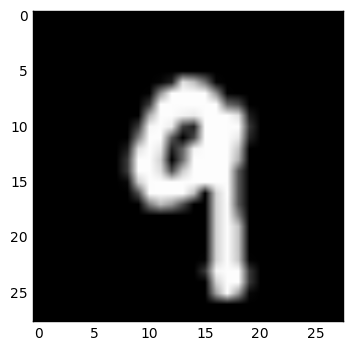

In [5]:
## DATA EXPLORATION & VISUALIZATION
index=np.random.randint(0,n_train)
image=train_data[index][0]
plt.imshow(np.reshape(image,(28,28)),cmap='gray')
print "Label ",train_data[index][1].T

----

## Step 2: Model Architecture

Using simplified architecture described by Michael Nielson (not a CNN)

net = network.Network([784, 30, 10])
<br>
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

In [6]:
def Model_evaluate(model,test_image):
    one_hot_output=np.round(model.feedforward(test_image),2)
    predicted_label=np.argmax(model.feedforward(test_image))
    return one_hot_output,predicted_label

Actual Label:  0
One-Hot labeling:  [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Predicted Label:  0


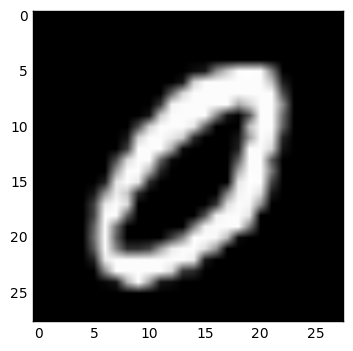

In [7]:
index=np.random.randint(0,n_test)
test_image=test_data[index][0]
plt.imshow(np.reshape(test_image,(28,28)),cmap='gray')
print "Actual Label: ",test_data[index][1]

one_hot_output,predicted_label=Model_evaluate(nn_load,test_image)
print "One-Hot labeling: ",one_hot_output.T
print "Predicted Label: ",predicted_label

---

## Step 3: Adversarial images implementation

#### Backpropagation Implementation, Non-targeted attack, Targeted attack

In [8]:
from network.network import sigmoid,sigmoid_prime

In [9]:
def backprop(biases,weights,num_layers,x):
    deriv_bias=[np.zeros(b.shape) for b in biases]
    deriv_weight=[np.zeros(w.shape) for w in weights]
    
    # Forward pass
    activation=x
    activation_list=[x]
    out_list=[]
    
    for bias,weight in zip(biases,weights):
        out=np.dot(weight,activation)+bias
        out_list.append(out)
        activation=sigmoid(out)
        activation_list.append(activation)
    
    # Backward Pass
    err=activation_list[-1]-target_label
    delta=err*sigmoid_prime(out_list[-1])
    deriv_bias[-1]=delta
    deriv_weight[-1]=np.dot(delta,activation_list[-2].transpose())
    
    for l_num in range(2,num_layers):
        out=out_list[-l_num]
        grad=sigmoid_prime(out)
        delta=np.dot(weights[-l_num+1].transpose(),delta)*grad
        deriv_bias[-l_num]=delta
        deriv_weight[-l_num]=np.dot(delta,activation_list[-l_num-1].transpose())
    
    return delta,deriv_bias,deriv_weight    

In [10]:
def nontargeted_attack(trained_weights,trained_biases,num_layers,image,target_label,descent_steps=1000,descent_stepsize=0.5):
    # Force predicted label to equal target label
    one_hot_target=np.zeros((10,1))
    one_hot_target[target_label]=1
    
    for _ in range(descent_steps):
        delta,deriv_bias,deriv_weight=backprop(trained_biases,trained_weights,num_layers,image)
        image-=descent_stepsize*(trained_weights[0].T.dot(delta))
    return image

In [11]:
image=np.random.rand(784,1)
num_layers=nn_load.num_layers
target_label=np.random.randint(0,n_classes[0]+1)
weight_values=nn_load.weights
bias_values=nn_load.biases

nontargeted_image=nontargeted_attack(weight_values,bias_values,
                   num_layers,image,target_label,
                   descent_steps=10000,descent_stepsize=0.5)

Target_label is  4 .


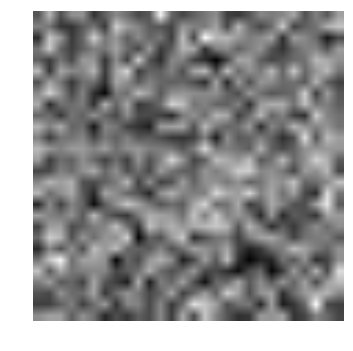

In [12]:
plt.imshow(np.reshape(nontargeted_image,(28,28)),cmap='gray')
plt.axis('off')
print "Target_label is ",target_label,"."
save_title='output_images/Nontargeted_'+str(target_label)
plt.savefig(save_title,bboxes_inches='Tight')

In [13]:
print "Nontargeted image evaluation"

nontarget_adversarial_onehot,nontarget_adversarial_predicted=Model_evaluate(nn_load,nontargeted_image)
print "One-Hot labeling: ",nontarget_adversarial_onehot.T
print "Predicted Label: ",nontarget_adversarial_predicted
# Predicted Label is not equal to the target label  (good attack)

Nontargeted image evaluation
One-Hot labeling:  [[ 0.  0.  1.  0.  0.  0.  1.  0.  0.  0.]]
Predicted Label:  2


In [14]:
def targeted_attack(trained_weights,trained_biases,num_layers,image,target_image,target_label,descent_steps,descent_stepsize,lambda_reg):
    # Force predicted label to equal target label AND
    # Force output image to equal target image
    one_hot_target=np.zeros((10,1))
    one_hot_target[target_label]=1
    
    for _ in range(descent_steps):
        delta,deriv_bias,deriv_weight=backprop(trained_biases,trained_weights,num_layers,image)
        image-=descent_stepsize*(trained_weights[0].T.dot(delta)+lambda_reg*(image-target_image))
    return image

In [15]:
image=np.random.rand(784,1)
num_layers=nn_load.num_layers

index=np.random.randint(0,n_test)
target_image=test_data[index][0]
target_label=test_data[index][1]
weight_values=nn_load.weights
bias_values=nn_load.biases

targeted_image=targeted_attack(weight_values,bias_values,
                   num_layers,image,target_image,target_label,
                   descent_steps=10000,descent_stepsize=0.5,lambda_reg=0.1)



Target_label is  4 .


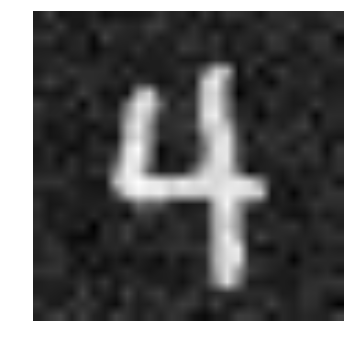

In [16]:
plt.imshow(np.reshape(targeted_image,(28,28)),cmap='gray')
plt.axis('off')
print "Target_label is ",target_label,"."
save_title='output_images/Targeted_'+str(target_label)
plt.savefig(save_title,bboxes_inches='Tight')

In [17]:
print "Targeted image evaluation"

target_adversarial_onehot,target_adversarial_predicted=Model_evaluate(nn_load,targeted_image)
print "One-Hot labeling: ",target_adversarial_onehot.T
print "Predicted Label: ",target_adversarial_predicted
# Predicted Label is not equal to the target label  (good attack)

Targeted image evaluation
One-Hot labeling:  [[ 0.  1.  0.  0.  0.  0.  1.  0.  0.  1.]]
Predicted Label:  9


In [ ]:
print("Script terminated at",str(datetime.now()))